In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import re
import string




In [47]:
df_fake = pd.read_csv('ML KNN Overview Fake.txt', header=None)
df_real = pd.read_csv('ML KNN Overview Real.txt', header=None)

# Đặt tên cột là 'title'
df_fake.columns = ['title']
df_real.columns = ['title']

# Hiển thị 5 hàng đầu tiên của DataFrame
print(df_fake.head())
print(df_real.head())


                                               title
0           trump warns of vote flipping on machines
1  this election is not about trump its about a g...
2  more on trump populism and how it can be contr...
3  trump bollywood ad meant to sway indian americ...
4  dems could be up on charges for inciting trump...
                                               title
0  donald trump do you remember the year since he...
1  trump defends son over emails as moscow hits back
2  donald trump strategist says media wont easily...
3  anthony scaramucci who is donald trumps new co...
4  donald trumps mobile phone use worries securit...


### Inserting a column "class" as target feature

In [48]:
df_fake['class']=0
df_real['class']=1

In [49]:
df_fake.shape,df_real.shape

((1298, 2), (1968, 2))

In [50]:
# Additional preprocessing functions
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text

# Apply preprocessing
df_fake['title'] = df_fake['title'].apply(preprocess_text)
df_real['title'] = df_real['title'].apply(preprocess_text)

In [51]:
# Combine fake and real data
df = pd.concat([df_fake, df_real])
X = df['title']
y = df['class']


In [52]:
df


,title,class
0,trump warns of vote flipping on machines,0
1,this election is not about trump its about a g...,0
2,more on trump populism and how it can be contr...,0
3,trump bollywood ad meant to sway indian americ...,0
4,dems could be up on charges for inciting trump...,0
...,...,...
1963,donald trump tells guam north korean threat a ...,1
1964,abc news quiz trump golden globes,1
1965,cancel it trump says new air force one cost ri...,1
1966,trump trade policies easier said than done,1


## Split the data set

In [53]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature extraction using TF-IDF
max_features = 5000  # Limit the number of features
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, max_features=max_features)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Oversampling

Shape of training data before oversampling: (2612, 4933) 




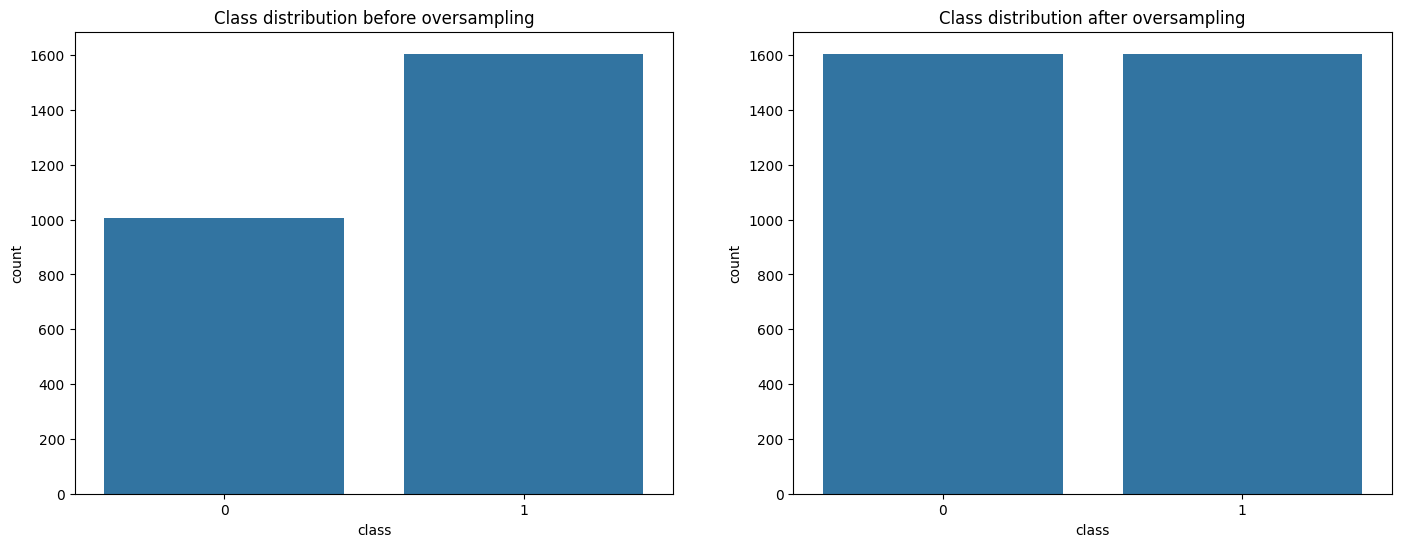

Shape of training data after oversampling: (3210, 4933)


In [55]:
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# Visualize class imbalance before oversampling
plt.figure(1, figsize=(17, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Class distribution before oversampling')
print('Shape of training data before oversampling:', X_train_tfidf.shape, '\n\n')
# Perform oversampling using RandomOverSampler
ros = RandomOverSampler()
X_train_tfidf_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)

# Visualize class distribution after oversampling
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_res)
plt.title('Class distribution after oversampling')
plt.show()
print('Shape of training data after oversampling:', X_train_tfidf_res.shape)



Number of components: 3000
Dimensions required for 95 percent explained variance: 1807
Variance Explained: 0.9500681116852854


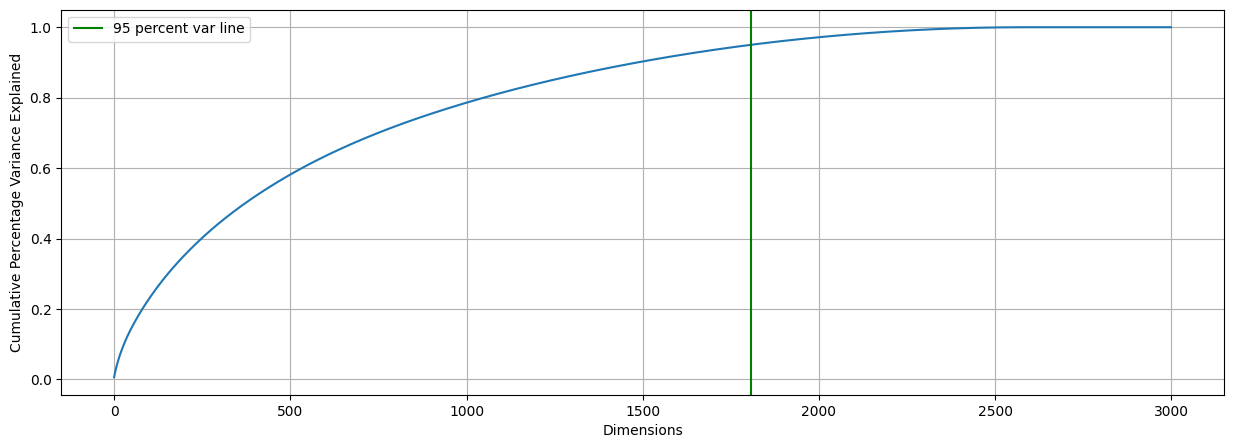

In [60]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=3000)
pca.fit(X_train_tfidf_res.toarray())  # Fit PCA with the resampled training data

explained_variance = pca.explained_variance_ratio_
print('Number of components:', len(explained_variance))

# Calculate the number of components required to retain 95% of the variance
dim_req_var = sum(np.cumsum(explained_variance) <= 0.95)
print('Dimensions required for 95 percent explained variance:', dim_req_var)
print('Variance Explained:', np.cumsum(explained_variance)[dim_req_var])

# Plot the cumulative explained variance
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(list(range(len(explained_variance))), np.cumsum(explained_variance))
plt.axvline(x=dim_req_var, color='g', label='95 percent var line')
plt.xlabel('Dimensions')
plt.ylabel('Cumulative Percentage Variance Explained')
plt.legend()
plt.show()

# Reduce the dimensionality of the train, cross-validation, and test data
X_train_bow_pca = pca.transform(X_train_tfidf_res.toarray())[:, :dim_req_var]
X_test_bow_pca = pca.transform(X_test_tfidf.toarray())[:, :dim_req_var]

# Further split the training data for cross-validation
X_train_bow_pca, X_cv_bow_pca, y_train, y_cv = train_test_split(X_train_bow_pca, y_train_res, test_size=0.25, random_state=42)


100%|██████████| 5/5 [00:00<00:00,  7.62it/s]


Maximum accuracy is 0.8754669987546699 with C value 10
Maximum F1 score on CV data for positive label is 0.878345498783455 with C value 10
Maximum F1 score on CV data for negative label is 0.8724489795918368 with C value 10


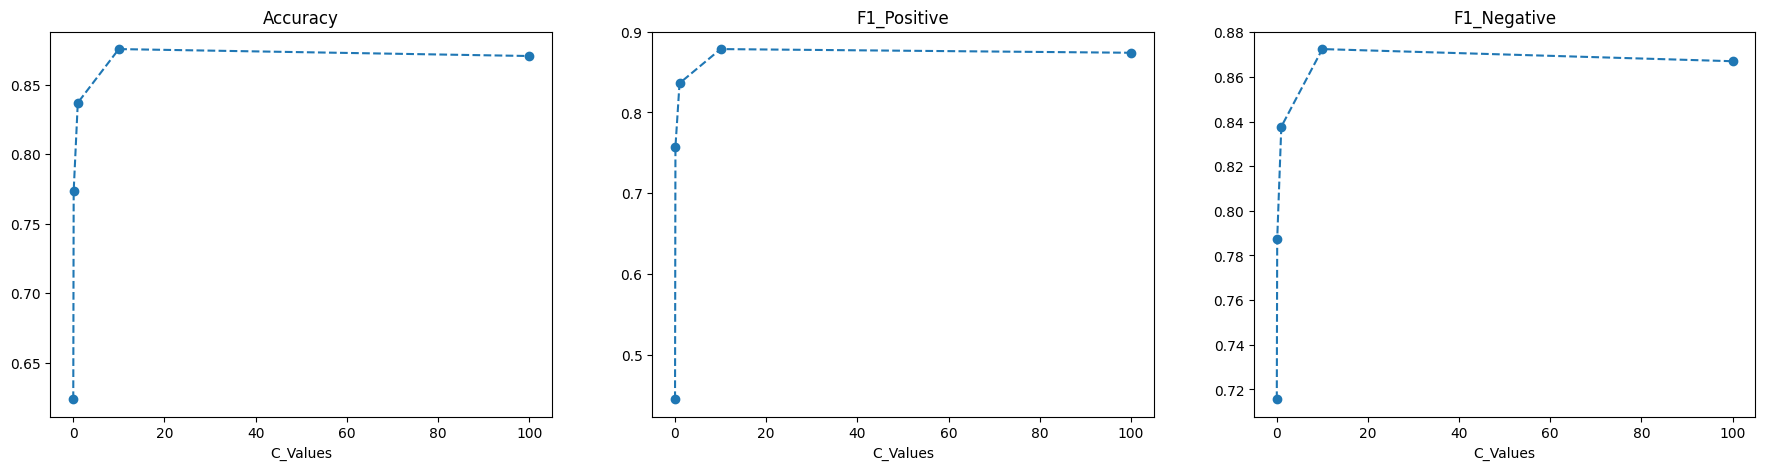


Confusion matrix:
               pred_positive  pred_negative
true_positive            311             52
true_negative             72            219

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       291
           1       0.81      0.86      0.83       363

    accuracy                           0.81       654
   macro avg       0.81      0.80      0.81       654
weighted avg       0.81      0.81      0.81       654


Accuracy on Test Data: 0.8103975535168195


In [63]:
from sklearn.metrics import f1_score
from tqdm import tqdm
# Initialize arrays to store evaluation metrics
accuracy = []
f1_positive = []
f1_negative = []
C_values = [0.01, 0.1, 1, 10, 100]  # Range of C values for Logistic Regression

# Loop through different C values to find the best one
for c in tqdm(C_values):
    lr = LogisticRegression(C=c)  # Initialize Logistic Regression with regularization strength C
    lr.fit(X_train_bow_pca, y_train)  # Train the model on training data
    pred = lr.predict(X_cv_bow_pca)  # Predict labels for cross-validation data

    # Calculate and store evaluation metrics
    f1_positive.append(f1_score(y_cv, pred, pos_label=1))  # assuming 1 is the positive label
    f1_negative.append(f1_score(y_cv, pred, pos_label=0))  # assuming 0 is the negative label
    accuracy.append(accuracy_score(y_cv, pred))

# Find the index of the best values for each metric
positive_ind = f1_positive.index(max(f1_positive))
negative_ind = f1_negative.index(max(f1_negative))
acc_ind = accuracy.index(max(accuracy))

# Print the best results
print('Maximum accuracy is {a} with C value {b}'.format(a=max(accuracy), b=C_values[acc_ind]))
print('Maximum F1 score on CV data for positive label is {a} with C value {b}'.format(a=max(f1_positive), b=C_values[positive_ind]))
print('Maximum F1 score on CV data for negative label is {a} with C value {b}'.format(a=max(f1_negative), b=C_values[negative_ind]))

# Plot the metrics for different C values
plt.figure(1, figsize=(22, 5))
plt.subplot(1, 3, 1)
plt.plot(C_values, accuracy, 'o--')
plt.title('Accuracy')
plt.xlabel('C_Values')

plt.subplot(1, 3, 2)
plt.plot(C_values, f1_positive, 'o--')
plt.title('F1_Positive')
plt.xlabel('C_Values')

plt.subplot(1, 3, 3)
plt.plot(C_values, f1_negative, 'o--')
plt.title('F1_Negative')
plt.xlabel('C_Values')

plt.show()

# Train the best Logistic Regression model on the training data and evaluate on the test data
best_c = C_values[acc_ind]
lr = LogisticRegression(C=best_c)
lr.fit(X_train_bow_pca, y_train)
pred = lr.predict(X_test_bow_pca)

# Create confusion matrix and classification report
confusion_mat = pd.DataFrame(confusion_matrix(y_test, pred, labels=[1, 0]), columns=['pred_positive', 'pred_negative'], index=['true_positive', 'true_negative'])
print('\nConfusion matrix:')
print(confusion_mat)
print('\nClassification Report:')
print(classification_report(y_test, pred))
print('\nAccuracy on Test Data:', accuracy_score(y_test, pred))

### Training model with LogisticRegression

In [56]:
model=LogisticRegression()
model.fit(X_train_tfidf_res, y_train_res)

LogisticRegression()

In [57]:
y_pred=model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

In [58]:

print(f'Accuracy: {accuracy * 100:.2f}%')
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
class_report = classification_report(y_test, y_pred)
print(class_report)


Accuracy: 81.80%
[[232  59]
 [ 60 303]]
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       291
           1       0.84      0.83      0.84       363

    accuracy                           0.82       654
   macro avg       0.82      0.82      0.82       654
weighted avg       0.82      0.82      0.82       654



## Descision Tree


In [65]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(X_train_tfidf_res, y_train_res)


DecisionTreeClassifier()

In [67]:
pred_dt = DT.predict(X_test_tfidf)


In [69]:
DT.score(X_test_tfidf, y_test)


0.7293577981651376

In [70]:
print(classification_report(y_test, pred_dt))


              precision    recall  f1-score   support

           0       0.71      0.67      0.69       291
           1       0.75      0.78      0.76       363

    accuracy                           0.73       654
   macro avg       0.73      0.72      0.72       654
weighted avg       0.73      0.73      0.73       654

